# Object-Oriented Demo

---

How `climpred` would look with an object-oriented philosophy.

In [1]:
import numpy as np
import xarray as xr
import climpred as cp
import matplotlib.pyplot as plt
%matplotlib inline

Load in demo datasets and process them

In [2]:
def _load_dple():
    dple = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                     'CESM-DP-LE.SST.annmean.anom.nc')['anom']
    dple = dple.sel(S=slice(1955, 2015))
    dple = dple.mean('M')
    dple = dple.rename({'S': 'initialization', 'L': 'time'})
    dple.name = 'SST'
    return dple

def _load_fosi():
    fosi = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                       'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.SST.024901-031612.nc')['SST']
    fosi = fosi.sel(time=slice('1955', '2015'))
    fosi = fosi.groupby('time.year').mean('time')
    fosi = fosi.rename({'year': 'initialization'})
    return fosi

def _load_data():
    data = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                           'ERSSTv4.global.mean.nc')['sst']
    data = data.rename({'year': 'initialization'})
    data.name = 'SST'
    return data

dple = _load_dple().to_dataset()
fosi = _load_fosi().to_dataset()
data = _load_data().to_dataset()

There are currently two types of objects (like `dataset` and `dataarray`). One is the `ReferenceEnsemble`, which are ensembles that are initialized off of something like a reconstruction or data. The other is a `PerfectModelEnsemble`, like MPI's setup.

In [3]:
dp = cp.ReferenceEnsemble(dple)
print(dp)

<climpred.ReferenceEnsemble>
Initialized Ensemble:
    SST      (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
References:
    None


For a `ReferenceEnsemble` type, you can add multiple references. Here, we will add the reconstruction (FOSI) and a dataset (ERSST). Multiple checks go into play here under the hood, ensuring that dimensions are named according to our rules and that references match all initialized dimensions (except for `time`). 

We can also have multiple variables per reference and decadal prediction object.

In [4]:
dple['SALT'] = _load_dple()
fosi['SALT'] = ('initialization', np.random.randn(61))
data['SALT'] = ('initialization', np.random.randn(61))

In [5]:
dp = cp.ReferenceEnsemble(dple)
dp.add_reference(fosi, 'FOSI')
dp.add_reference(data, 'ERSST')
print(dp)

<climpred.ReferenceEnsemble>
Initialized Ensemble:
    SST      (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
    SALT     (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
FOSI:
    SST      (initialization) float32 16.255846 16.252129 ... 16.714994
    SALT     (initialization) float64 0.04307 0.1246 0.9466 ... -1.998 2.304
ERSST:
    SST      (initialization) float32 ...
    SALT     (initialization) float64 -0.2143 0.0452 1.27 ... 1.071 0.08761


Now we can apply our functions to our `ReferenceEnsemble` object. You can call `compute_skill` in two different ways:

1. Declaring a single reference you want to compute skill with regard to (this returns a single xr.Dataset with skill results for that

2. Running `compute_skill` with no arguments, which computes skill for all available references. This returns a dictionary with each of your reference results.

In [6]:
# only want skill for FOSI.
skill = dp.compute_skill('FOSI')
print(skill)

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 -0.1346 -0.05851 -0.08545 ... -0.04915 -0.03644


In [7]:
# want skill for all references
skill = dp.compute_skill()
print(skill['FOSI'])
print(skill['ERSST'])

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 -0.1346 -0.05851 -0.08545 ... -0.04915 -0.03644
<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.92809033 0.8993258 ... 0.915254 0.91362256
    SALT     (time) float64 0.1225 0.05945 0.0847 ... 0.1077 0.0888 0.1262


We can also compute a persistence forecast.

In [8]:
dp.compute_persistence('FOSI')

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.7159944 0.5045179 ... 0.44596496 0.5347486
    SALT     (time) float64 0.09441 -0.1138 -0.1492 ... -0.1933 -0.01634 0.07843

In [9]:
persist = dp.compute_persistence()
print(persist['FOSI'])
print(persist['ERSST'])

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.7159944 0.5045179 ... 0.44596496 0.5347486
    SALT     (time) float64 0.09441 -0.1138 -0.1492 ... -0.1933 -0.01634 0.07843
<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.91231585 0.83529794 ... 0.83016926 0.8554033
    SALT     (time) float64 -0.05742 -0.1514 -0.1056 ... -0.1529 -0.06572 0.2229


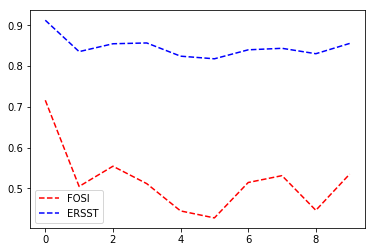

In [10]:
plt.plot(persist['FOSI'].SST, color='r', linestyle='--', label='FOSI')
plt.plot(persist['ERSST'].SST, color='b', linestyle='--', label='ERSST')
plt.legend()